# Google Trends analytics using Python
- Here we will be analyzing the Google search trends on the queries of our intered {You will get a chance to provide input}.

In [79]:
#!pip install pytrends
#!pip install pycountry-convert # for mapplot
#!pip install geopy
#!pip install folium

***Start with importing libraries.***
---
*Probably need to run "pip install pytrends"*

In [80]:
# import necessary libaries
import pandas as pd
import numpy as np

from pytrends.request import TrendReq

import matplotlib.pyplot as plt
import seaborn as sns
from seaborn import load_dataset

import warnings
warnings.filterwarnings("ignore")

import re
from textblob import TextBlob
from wordcloud import WordCloud

from spacy.lang.en.stop_words import STOP_WORDS as en_stop #stopwords in English
from spacy.lang.da.stop_words import STOP_WORDS as da_stop #stopwords in Danish
final_stopwords= en_stop.union(da_stop)

# Connect to google and Build Payload
> The build_payload method from Pytrends is used to build a list of keywords that want to search in Google Trends. Can also specify the timeframe to gather data and the category to query the data from.
---
*kw_list:* list of the target search terms 

*cat:* Category to narrow result fx. Art, Entertainment.[link for category](https://github.com/pat310/google-trends-api/wiki/Google-Trends-Categories)

*timeframe:* Date to start from fx. Defaults to last 5yrs is 'today 5-y' or Everything is 'all'

*geo:* Location of interest represent by two letter country abbreviation fx. United States is 'US' or Defaults to World

*gprop:* What Google property to filter to fx. "image" or "news" default to web searches

In [97]:
# Function for connecting google and build playload
def pytrends_func(kw_list, timeframe):
  # Configuring connection wich receives two important parameters; hl (hosting language) & tz (timezone).
  trends = TrendReq(hl='en-US', tz= 360, timeout=(10,25))
  
  # Update playload
  trends.build_payload(kw_list=kw_list, cat=71, timeframe=timeframe, geo= '', gprop='') #timeframe='today 5-y', cat 0(all), 45(Health), Food & Drink: 71
  
  # return the trends object
  return trends

kw_list = ["High-protein diet"] 
trends= pytrends_func(kw_list, 'today 12-m')
trends

# What kind of data want to pull? possible methods are:
- ***Interest Over Time:*** returns historical, indexed data for when the keyword was searched
- Historical Hourly Interest:  returns historical, indexed, hourly data for when the keyword was searched
- ***Interest by Region:*** returns data for where the keyword is most searched
- Related Topics: returns data for the related keywords to a provided keyword
- Related Queries: returns data for the related keywords to a provided keyword
- ***Trending Searches:*** returns data for latest trending searches
- Top Charts: returns the data for a given topic
- Suggestions: returns a list of additional suggested keywords that can be used to refine a trend search.

In [98]:
# Function to Disply in the figure
def display_lineplot(df, x, kw_list, title, x_label, y_label):
    """ The function will take x & value including title, x_label & y_label then display the figure"""
    fig, ax = plt.subplots(figsize= (10, 5))  # Create a figure containing a single axes. Alt-figsize= (10, 5)#, layout='constrained'
    
    # loop over columns to dorw line-plot and add to the figure
    for col in kw_list:
      ax.plot(df[x], df[col], label = col)

    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.xticks(rotation=45)
    plt.legend()  # Add a legend.
    #ax.grid(axis= "y")
    plt.grid(b = True, color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.2)# Add x, y gridlines
    plt.show()

def display_barplot(df, x_col, kw_list, title):
  fig, ax = plt.subplots(figsize= (10, 5))
  
  # loop over columns to dorw line-plot and add to the figure
  for col in kw_list:
    ax.bar(df[x_col], df[col], width=0.25, label= col)#, color ='blue', width = 0.4

  plt.title(title, fontsize=12)
  plt.xticks(rotation=45)
  plt.xlabel(x_col)
  plt.ylabel("Values")
  plt.legend()  
  #plt.grid(b = True, color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.2)# Add x, y gridlines
  ax.grid(axis= "y")
  plt.show()


***Interest Over Time***

,date,High-protein diet
46,2022-08-21,0
47,2022-08-28,0
48,2022-09-04,33
49,2022-09-11,0
50,2022-09-18,0


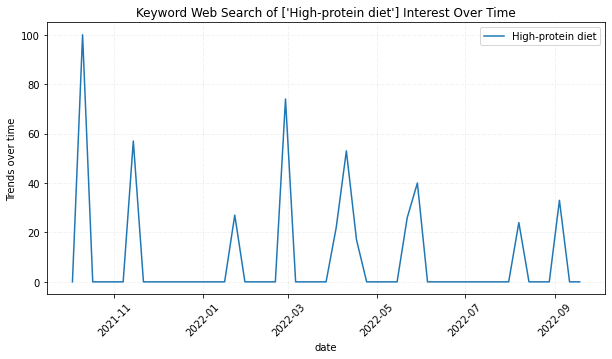

In [99]:
# function to extract interest over time
def gt_trends_over_time():
  # Interest Over Time
  data_over_time= trends.interest_over_time().drop(columns='isPartial')
  data_over_time = data_over_time.reset_index(drop=False)
  return data_over_time

display(gt_trends_over_time().tail())
data_over_time= gt_trends_over_time()

# Disply figure as lineplot
display_lineplot(data_over_time, "date", kw_list, title= f'Keyword Web Search of {kw_list} Interest Over Time', x_label= "date", y_label="Trends over time")

**Historical Hourly Interest**

,date,High-protein diet
2,2022-09-01 02:00:00,36
20,2022-09-01 20:00:00,40
24,2022-09-02 00:00:00,35
28,2022-09-02 04:00:00,38
40,2022-09-02 16:00:00,19


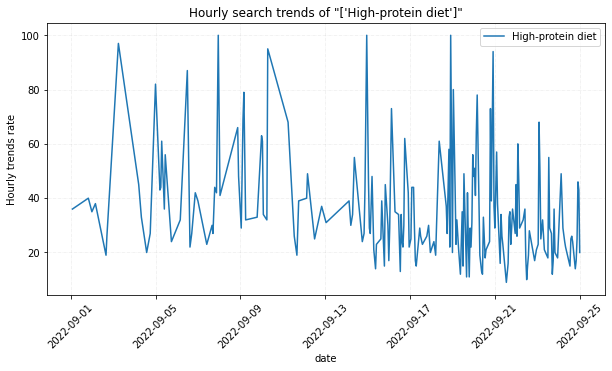

In [100]:
# Function for Historical hourly interest
def gt_hh_trends():
  # Historical Hourly Interest (The hourly interest of the keyword)
  hourly_trends= trends.get_historical_interest(kw_list, year_start=2022, month_start=9, day_start=1, hour_start=0, year_end=2022, month_end=9, day_end=25, hour_end=0, cat=0, sleep=0)
  hourly_trends = hourly_trends.reset_index().drop(columns='isPartial')
  return hourly_trends[hourly_trends[kw_list[0]]> 0]

data_hourly_trends=gt_hh_trends()
display(data_hourly_trends.head())

# Disply figure as lineplot
display_lineplot(data_hourly_trends, "date", kw_list, title= f'Hourly search trends of "{kw_list}"', x_label= "date", y_label="Hourly trends rate")


**Interest by Region(Search by geographical region)**

To show you which countries search the keyword on a scale of 0 to 100, where 100 represents a country with the most search

*The resolution value is dependent on the geo parameter of the common configuration:*

*Use resolution='COUNTRY' for geo='World'*

*Use resolution='REGION' for geo='US', Two letter country abbreviation. for example*

*gprop= What Google property to filter to.Can be `images, news, youtube or froogle`*

,geoName,High-protein diet
0,United States,100
1,Philippines,35
2,Canada,33
3,India,29
4,Australia,29


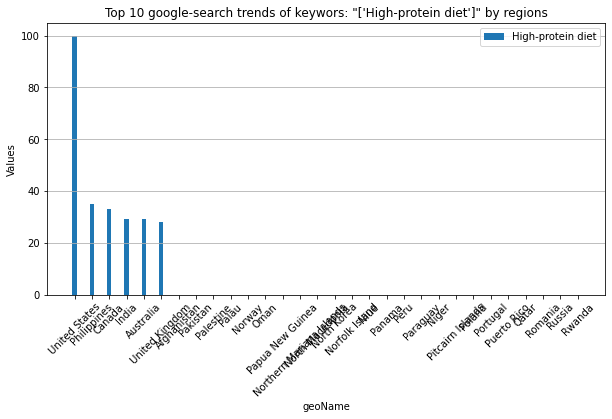

In [101]:
# Function for interest by region
def gt_trends_byregion():
  #trends= pytrends_func(["Healthy diet"], 'today 12-m', geo='', gprop='')
  # resolution can be either CITY, COUNTRY or REGION
  trends_by_region= trends.interest_by_region(resolution= 'COUNTRY', inc_low_vol=False, inc_geo_code=False)

  trends_by_region = trends_by_region.sort_values(by=kw_list[0], ascending=False).reset_index()
  return trends_by_region

df_byregion= gt_trends_byregion()
display(df_byregion.head())

display_barplot(df_byregion.iloc[:30,:], "geoName", kw_list, f'Top 10 google-search trends of keywors: "{kw_list}" by regions')


In [86]:
# for map-plot
from pycountry_convert import country_alpha2_to_continent_code, country_name_to_country_alpha2

# function yo display in map
def display_mapplot(df_byregion, kw_list):
  # Data with two columns
  for kw in kw_list:
    df_byregion[f'{kw}_%']= df_byregion[kw].apply(lambda x: x*0.01)
    #df_byregion["Healthy_food%"]= df_byregion["Healthy food"].apply(lambda x: x*0.01)

  # Conversion to Alpha 2 codes and Continents
  #function to convert to alpah2 country codes and continents
  def get_continent(col):
    try:
      cn_a2_code =  country_name_to_country_alpha2(col)
    except:
      cn_a2_code = 'Unknown' 
    try:
      cn_continent = country_alpha2_to_continent_code(cn_a2_code)
    except:
      cn_continent = 'Unknown'
    return (cn_a2_code, cn_continent)

  #Apply function to get Alpha 2 codes and Continents
  df_byregion["codes"]= df_byregion["geoName"].apply(get_continent)
  df_byregion["Country"]= df_byregion["codes"].apply(lambda x: x[0])
  df_byregion["Continent"]= df_byregion["codes"].apply(lambda x: x[1])

  # Get longitude and latitude
  #function to get longitude and latitude data from country name
  from geopy.geocoders import Nominatim
  geolocator = Nominatim()
  def geolocate(country):
    try:
      # Geolocate the center of the country
      loc = geolocator.geocode(country)
      # And return latitude and longitude
      return (loc.latitude, loc.longitude)
    except:
      # Return missing value
      return (0, 0)

  # Apply function to get Alpha 2 codes and Continents
  df_byregion["Geolocate"]= df_byregion["Country"].apply(geolocate)
  df_byregion["Latitude"]= df_byregion["Geolocate"].apply(lambda x: x[0])
  df_byregion["Longitude"]= df_byregion["Geolocate"].apply(lambda x: x[1])
  display(df_byregion)
  
  ## Create a world map
  # Create a world map to show distributions of users 
  import folium
  from folium.plugins import MarkerCluster

  #empty map
  world_map= folium.Map(tiles="cartodbpositron")
  marker_cluster = MarkerCluster().add_to(world_map)

  #for each coordinate, create circlemarker of user percent
  for i in range(len(df_byregion)):
    lat = df_byregion.iloc[i]['Latitude']
    long = df_byregion.iloc[i]['Longitude']
    radius=5
    popup_text = """Country : {}, <br> %of search: {}<br>"""
    popup_text = popup_text.format(df_byregion.iloc[i]['geoName'], df_byregion.iloc[i][kw_list[0]])

    folium.CircleMarker(location = [lat, long], radius=radius, popup= popup_text, fill =True).add_to(marker_cluster)
  #show the map
  return world_map

  #return df_byregion

display_mapplot(df_byregion.iloc[:20,:], kw_list)

,geoName,Protein diet,Protein diet_%,codes,Country,Continent,Geolocate,Latitude,Longitude
0,Ireland,100,1.00,"(IE, EU)",IE,EU,"(52.865196, -7.9794599)",52.865196,-7.979460
1,Jamaica,95,0.95,"(JM, NA)",JM,NA,"(18.1850507, -77.3947693)",18.185051,-77.394769
2,Australia,93,0.93,"(AU, OC)",AU,OC,"(-24.7761086, 134.755)",-24.776109,134.755000
3,United States,93,0.93,"(US, NA)",US,NA,"(39.7837304, -100.445882)",39.783730,-100.445882
4,United Kingdom,84,0.84,"(GB, EU)",GB,EU,"(54.7023545, -3.2765753)",54.702354,-3.276575
5,Lebanon,82,0.82,"(LB, AS)",LB,AS,"(33.8750629, 35.843409)",33.875063,35.843409
6,Ghana,82,0.82,"(GH, AF)",GH,AF,"(8.0300284, -1.0800271)",8.030028,-1.080027
7,South Africa,82,0.82,"(ZA, AF)",ZA,AF,"(-28.8166236, 24.991639)",-28.816624,24.991639
8,Pakistan,80,0.80,"(PK, AS)",PK,AS,"(30.3308401, 71.247499)",30.330840,71.247499
9,New Zealand,78,0.78,"(NZ, OC)",NZ,OC,"(-41.5000831, 172.8344077)",-41.500083,172.834408


**Related Queries**

In [102]:
#function for releted queries
def gt_related_queries():
  # Related Queries (keywords that are closely tied to a primary keyword of the choice)
  related_queries= trends.related_queries()
  df= pd.DataFrame()# Empty dataframe
  for kw in kw_list:
    df1= related_queries[kw]['top']
    df= pd.concat([df, df1], axis = 1)
  return df

releted_queries=gt_related_queries()
releted_queries.head()


,query,value
0,high protein diet,100
1,high-protein diet for weight loss,70
2,high protein foods,24
3,high-protein diet plan for weight loss,23
4,high-protein diet menu,15


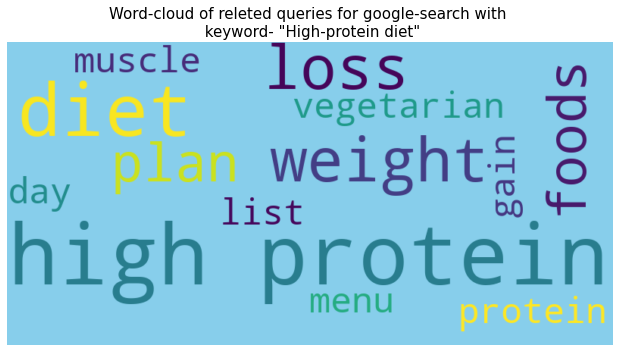

In [106]:
def cleanText(text):
      text= re.sub(r'@[A-Za-z0-9]+', '',text) # Removed @mentions
      text= re.sub(r'#', '',text) # the '#' symbol
      text= re.sub(r':', '',text) # the ':' symbol
      text= re.sub(r'RT[\s]+', '',text) # Removed RT
      text= re.sub(r'https?:\/\/\s+', '',text) # Removed the hyper link
      return text
      
#Function for word-cloud
def wordcloud_plot(releted_queries, title):
  #lets clean the xext first
  releted_queries["query"]= releted_queries["query"].apply(cleanText)
  # Create stopword list
  final_stopwords.update(['https', 'er', 'og', 't', 'co', 'A', 't','The'])
  
  plt.figure(figsize=(10,5))
  allWords= ' '.join( [twts for twts in releted_queries["query"]] )
  wordcloud = WordCloud(stopwords=final_stopwords, max_words=300, width= 800, height=400, random_state=21, max_font_size= 150, background_color="skyblue").generate(allWords)
  
  plt.imshow(wordcloud, interpolation = "bilinear")
  plt.title(title, fontsize=15)
  plt.axis('off')
  plt.tight_layout()
  plt.show()

for kw in kw_list:
  wordcloud_plot(releted_queries.iloc[:, 0:2], f'Word-cloud of releted queries for google-search with \n keyword- "{kw}"')


**Trending topics of the year**

In [104]:
# Function for topics of the year
def gt_topics_ofthe_year():
  df= pd.DataFrame()# Empty dataframe
  # loop over the year to extract data for each year and put in dataframe as columns
  for year in range(2004, 2022):
      trending = trends.top_charts(year, hl= "en-US", tz=300, geo= "GLOBAL")
      df[year]= trending.title     
  return df.iloc[:, 9:19].head(15)

gt_topics_ofthe_year()

,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,Oscar Pistorius,Robin Williams,Lamar Odom,Pokémon Go,Hurricane Irma,World Cup,India vs South Africa,Coronavirus,Australia vs India
1,Aaron Hernandez,World Cup,Charlie Hebdo,iPhone 7,iPhone 8,Avicii,Cameron Boyce,Election results,India vs England
2,Adrian Peterson,Ebola,Agar.io,Donald Trump,iPhone X,Mac Miller,Copa America,Kobe Bryant,IPL
3,Kevin Ware,Malaysia Airlines,Jurassic World,Prince,Matt Lauer,Stan Lee,Bangladesh vs India,Zoom,NBA
4,Lance Armstrong,ALS Ice Bucket Challenge,Paris,Powerball,Meghan Markle,Black Panther,iPhone 11,IPL,Euro 2021
5,Gareth Bale,Flappy Bird,Furious 7,David Bowie,13 Reasons Why,Meghan Markle,Game of Thrones,India vs New Zealand,Copa América
6,Jason Collins,Conchita Wurst,Fallout 4,Deadpool,Tom Petty,Anthony Bourdain,Avengers: Endgame,Coronavirus update,India vs New Zealand
7,Lamar Odom,ISIS,Ronda Rousey,Olympics,Fidget Spinner,XXXTentacion,Joker,Coronavirus symptoms,T20 World Cup
8,Ray Lewis,Frozen,Caitlyn Jenner,Slither.io,Chester Bennington,Stephen Hawking,Notre Dame,Joe Biden,Squid Game
9,Chris Kelly,Sochi Olympics,American Sniper,Suicide Squad,India National Cricket Team,Kate Spade,ICC Cricket World Cup,Google Classroom,DMX


**Trending Searches (latest trending searches) in a Specific Country**
---
*It highlight stories that are trending across Google surfaces within the last 24 hours and are updated in real-time*

-The` "pn"` argument specifies the geographical location, the name of country in small letter.

In [90]:
# Functing to get latest trending searches
def latest_trending_searches(country_dict):
  df_trends= pd.DataFrame()# Empty dataframe
  for country_key, country_val in country_dict.items():
    df_trends[country_key] = trends.trending_searches(pn= country_val)
  return df_trends.head(5)

country_dict= {"Denmark":"denmark", "United_State":"united_states", "Sweden":"sweden", "India":"india"}
latest_trending_searches(country_dict)

,Denmark,United_State,Sweden,India
0,Holy Spider,Ned Fulmer,Brynäs,Mahesh Babu
1,BBC,Deadpool 3,FOTBOLL,Deepika Padukone
2,CNN,Chloe Grace Moretz Family Guy meme,Bioarctic,Bigg Boss 16
3,Ned Fulmer,Nord Stream,Henrik Nyblom,Lata Mangeshkar
4,Dean Lewis,The Munsters,Mikael Ishak,Deadpool 3


#Realtime Search Trends
**- Country code in CAPITAL**

- *Realtime Search Trends highlight stories that are trending across Google surfaces within the last 24 hours, and are updated in realtime.*

In [91]:
# Function for Realtime Search Trends
def realtime_search_trends(country_dict):
  df_trends= pd.DataFrame()# Empty dataframe

  for country_key, country_val in country_dict.items():
    df_trends[country_key] = trends.realtime_trending_searches(pn=country_val)["title"]
    
  return df_trends.head(10)

country_dict= {"United_State":"US", "Russia":"RU", "Sweden":"SE", "Germeny":"DE"}
realtime_search_trends(country_dict)

,United_State,Russia,Sweden,Germeny
0,"Mexico national football team, Mexico, Colombi...","Wolverine, Deadpool, Hugh Jackman, Ryan Reynolds","Brynäs IF, Swedish Hockey League, Swedish Wome...","Hellabrunn Zoo, Giant panda, Ailurus, Red pand..."
1,"Tornado, National Weather Service, Tornado war...","Russia, Embassy","Scotland national football team, Ukraine natio...","Prince Harry, Duke of Sussex, Meghan, Duchess ..."
2,"Tornado, Delray Beach, Palm Beach County, Trop...","Ana de Armas, Blonde, Marilyn Monroe, Netflix,...","Helsingborgs IF, Noah Christoffersson, IF Elfs...","Southside Festival, Hurricane Festival, Die Är..."
3,"Argentina national football team, Jamaica nati...","North Korea, Nuclear weapon, Nuclear weapons t...","Halloween, Michael Myers","Marilyn Monroe, Blonde, Netflix, Ana de Armas,..."
4,"Jim Cantore, Tropical cyclone, Meteorologist, ...","Amputation, Otradnoye, Saint Petersburg","Blonde, Marilyn Monroe, Ana de Armas, Andrew D...","AnnenMayKantereit, 2023, Cologne, RheinEnergie..."
5,"Tropical cyclone, Charleston, South Carolina L...","Saint Petersburg, Barium, House arrest, accused",Emporia Shopping Center,"Alzheimer's disease, Biogen, Eisai, Roche Hold..."
6,"Peru national football team, El Salvador natio...","The State Russian Museum, Mikhailovsky Palace,...","Ericsson, Vonage, Börje Ekholm, Russia","Ibbenbüren, vocational college in Germany, Sch..."
7,"Cape Coral, Tropical cyclone","hydroelectric power station, RusHydro, Cheboks...","Cuba, United States, Miguel Díaz-Canel","Kaspersky, 2022"
8,"Vietnam, Typhoon, Tropical cyclone, Flood, Da ...","Rybinsk, Winter, Daylight saving time","Mathieu van der Poel, UCI Road World Champions...","Hailey Bieber, Selena Gomez, Justin Bieber"
9,"2022, WhatsApp, September 28","FC Khimki, Directeur sportif, Russian Premier ...","Nasdaq Stockholm, OMX Stockholm 30, Kinnevik A...","Hayden Panettiere, Wladimir Klitschko, Child c..."
